In [1]:
from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
import xgboost as xgb

In [4]:
df_train = pd.read_csv('./data/train_1M.csv', nrows=500000) 
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [33]:
# MinMaxScaler             : 
# MaxAbsScaler             : 
# StandardScaler           : 
# RobustScaler             : 
# Normalizer               : 
# QuantileTransformer      : 
# PowerTransformer         : 

scaler = 'MinMaxScaler'

In [6]:
df_train = add_features(df_train)
df_train = clean_df(df_train)
df_train = df_train.reset_index()
df_train = df_train.drop(['index'], axis=1)
df_train, lat_scaler, lon_scaler = scale_gps(df_train, scaler)
df_train = drop_date(df_train)

Old size: 500000
New size: 481794


In [7]:
cols = df_train.columns.tolist()
cols.remove('fare_amount')

X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [8]:
matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

In [9]:
xgb_reg = xgb.XGBRegressor(tree_method="exact", predictor="cpu_predictor", verbosity=1, objective="reg:squarederror")

param_grid = {
    'n_estimators': [150],
    'max_depth': [5, 7, 9], 
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.4, 0.6, 0.8],
    'colsample_bylevel': [0.4, 0.6, 0.8],
    'learning_rate': [0.06, 0.075, 0.08, 0.1, 0.2],
    #'gamma' : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
    #'reg_alpha': [1.1, 1.2, 1.3],
    #'reg_lambda': [1.1, 1.2, 1.3],
    'min_child_weight': [1, 3, 5, 7, 9],
}

xgb_rscv = RandomizedSearchCV(xgb_reg, param_distributions=param_grid, 
                              scoring='neg_mean_squared_error', cv=10, 
                              verbose=3, random_state=40, n_jobs=-1)

search = xgb_rscv.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 18.8min finished


In [10]:
import pprint as pp
pp.pprint(search.best_estimator_.get_params())

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.6,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 9,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 150,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'predictor': 'cpu_predictor',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.9,
 'tree_method': 'exact',
 'verbosity': 1}


---

In [47]:
df_train = pd.read_csv('./data/train_10M.csv') 
df_train['pickup_datetime'] = df_train['pickup_datetime'].str.slice(0, 16)
df_train['pickup_datetime'] = pd.to_datetime(df_train['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

In [48]:
del(lat_scaler)
del(lon_scaler)

In [49]:
df_train = add_features(df_train)
df_train = clean_df(df_train)
df_train = df_train.reset_index()
df_train = df_train.drop(['index'], axis=1)
df_train, pca = pca_gps(df_train)
df_train, lat_scaler, lon_scaler = scale_gps(df_train, scaler)
df_train = drop_date(df_train)

Old size: 10000000
New size: 9633165


In [50]:
cols = df_train.columns.tolist()
cols.remove('fare_amount')

X = df_train[cols]
y = df_train['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [51]:
matrix_train = xgb.DMatrix(X_train,label=y_train)
matrix_test = xgb.DMatrix(X_test,label=y_test)

In [52]:
%%time

params = {
    'objective':'reg:squarederror',
    'eval_metric':'rmse',
    #
    'n_estimators': search.best_estimator_.get_params()['n_estimators'],
    'max_depth': search.best_estimator_.get_params()['max_depth'],
    'subsample': search.best_estimator_.get_params()['subsample'],
    'colsample_bytree': 0.6, #search.best_estimator_.get_params()['colsample_bytree'],
    'colsample_bylevel': search.best_estimator_.get_params()['colsample_bylevel'],
    'learning_rate': search.best_estimator_.get_params()['learning_rate'],
    #'gamma' : search.best_estimator_.get_params()['gamma'],
    #'reg_alpha': search.best_estimator_.get_params()['reg_alpha'],
    #'reg_lambda': search.best_estimator_.get_params()['reg_lambda'],
    'min_child_weight': search.best_estimator_.get_params()['min_child_weight'],
    #
    'silent': 0,
    'nthread': 8,
    'n_jobs': 8,
}

model = xgb.train(
    params=params,
    dtrain=matrix_train,
    num_boost_round=150,
    early_stopping_rounds=10,
    evals=[(matrix_test,'test')],
)

[01:53:32] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	test-rmse:13.0073
Will train until test-rmse hasn't improved in 10 rounds.
[1]	test-rmse:11.8176
[2]	test-rmse:10.7467
[3]	test-rmse:9.80119
[4]	test-rmse:8.95634
[5]	test-rmse:8.20898
[6]	test-rmse:7.54557
[7]	test-rmse:6.96577
[8]	test-rmse:6.47612
[9]	test-rmse:6.04448
[10]	test-rmse:5.64328
[11]	test-rmse:5.30839
[12]	test-rmse:5.00318
[13]	test-rmse:4.74291
[14]	test-rmse:4.52655
[15]	test-rmse:4.33936
[16]	test-rmse:4.19125
[17]	test-rmse:4.04934
[18]	test-rmse:3.9342
[19]	test-rmse:3.82824
[20]	test-rmse:3.74408
[21]	test-rmse:3.6772
[22]	test-rmse:3.61953
[23]	test-rmse:3.5627
[24]	test-rmse:3.52043
[25]	test-rmse:3.48332
[26]	test-rmse:3.45694
[27]	test-rmse:3.42609
[28]	test-rmse:3.40187
[29]	test-rmse:3.37995
[30]	test-rmse:3.3639
[31]	test-rmse:3.34681
[32]	test-rmse:3.3

In [53]:
y_pred = model.predict(matrix_test, ntree_limit=model.best_ntree_limit)
print('RMSE:', math.sqrt(mean_squared_error(y_test, y_pred)))
print('R^2 :', r2_score(y_test, y_pred))

RMSE: 3.124875131418679
R^2 : 0.8901991042694184


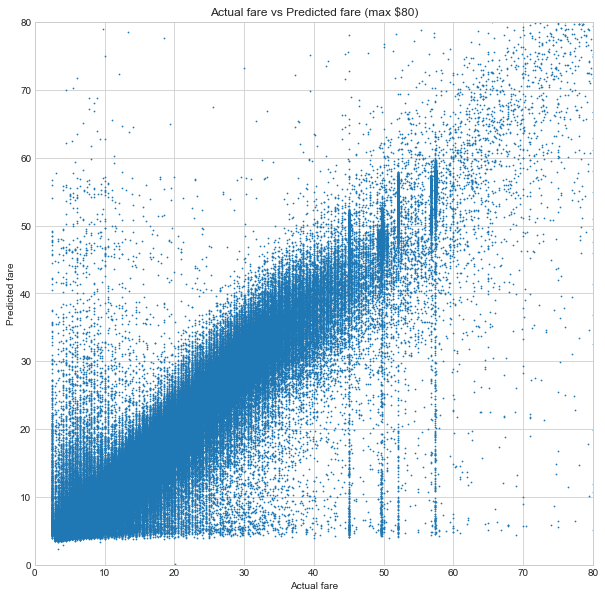

In [54]:
plot_predictions(y_test, y_pred)

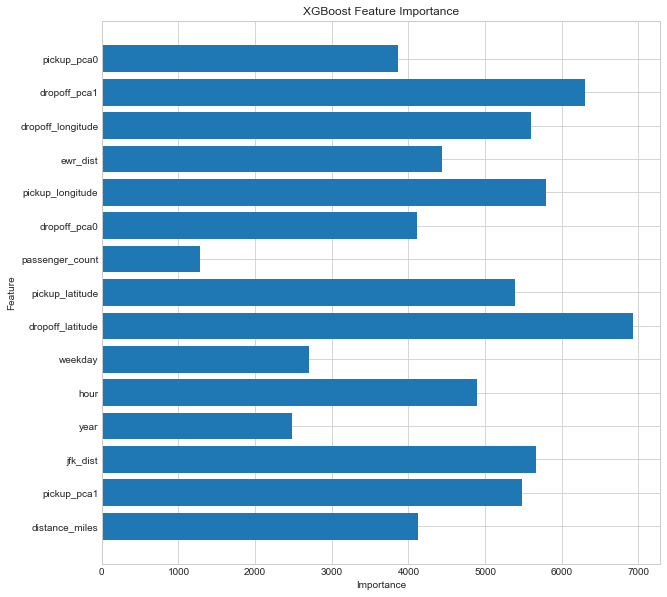

In [55]:
plt.figure(figsize=(10,10))
plt.barh(*zip(*model.get_fscore().items()))
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

---

# Creating the Kaggle submission file (prediction on official test set)

In [58]:
df_test = pd.read_csv('./data/test.csv') 
df_test['pickup_datetime'] = df_test['pickup_datetime'].str.slice(0, 16)
df_test['pickup_datetime'] = pd.to_datetime(df_test['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')

df_test = add_features(df_test)
df_test, pca = pca_gps(df_test, pca)
df_test, lat_scaler, lon_scaler = scale_gps(df_test, scaler, lat_scaler, lon_scaler)
df_test = drop_date(df_test)

df_test = df_test.drop(['key'], axis=1)

In [59]:
pred_test = model.predict(xgb.DMatrix(df_test), ntree_limit = model.best_ntree_limit)

In [60]:
df_test = pd.read_csv('./data/test.csv') 

submission = pd.DataFrame({
        "key": df_test['key'],
        "fare_amount": pred_test.round(2)
})

submission.to_csv('03_3_taxi_fare_submission_default.csv',index=False)